# POD-NN method

## The advection-diffusion problem

Let us  considere the following BVP. It is based on the 2D stationary advection-diffusion. It is here parametrized by the diffusivity coefficient $\lambda(\mu)$. The equations read: 

$$\begin{equation}
\begin{cases}
-div(\lambda(\mu)\nabla u)+w\nabla u&=f & in~~\Omega\\
~~~~~~  ~~~~~~~~~~~~~~~~~~ u&=g & in~~\varGamma_{in}\\
~~~~~~~-\lambda(\mu)\nabla u.n&=0 & in~~\varGamma_{wall}\\
~~~~~~~-\lambda(\mu)\nabla u.n&=0 & in~~\varGamma_{out}
\end{cases}
%\label{eq:Advection-non-affine}
\end{equation}$$

with $\lambda(\mu)=\exp(\mu_{0}(\mu + 1))$. The scalar $\mu_{0}=0.7$ and $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}],{~}  \mu_{min}=1,{~} \mu_{max}=10$.

### Modules  import and initializations

In [1]:
### Modules importation
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.datasets import mnist
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.losses as kloss
import tensorflow.keras.regularizers as kr
import tensorflow.keras.backend as K
import tensorflow.keras.utils as ku
from tensorflow.keras import callbacks
import scipy as sc
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import sys,os
import random 
#import pandas as pd
import sklearn.utils
# Verbosity
fit_verbosity = 1

2024-12-12 09:48:03.766737: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 09:48:03.803507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 09:48:04.008490: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 09:48:04.008580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 09:48:04.009514: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### Normalization and non-affine functions 

In [2]:
# The scaling function for data normalisation
# Scaling function
def scaling(S, S_max, S_min):
    S[ : ] = (S - S_min)/(S_max - S_min)
    
# Inverse scaling function
def inverse_scaling(S, S_max, S_min):
    S[ : ] = (S_max - S_min) * S + S_min
    
# The non-affinity function
def Lambda(mu):
    return np.exp(mu0*(mu+1.))

## The offline phase

### Preparing the data

The RB POD matrix $Brb=[\xi_{1},\dots,\xi_{M}]\in\mathbb{R}^{NN\times N_{rb}}$. The RB matrix is constructed by POD method. It is computed for 100 snapshots of Problem (1). The reduced matrix here is of size $N_{rb}=5$. $$\$$
For the training step of the NN, the snapshots matrix $S=[U_{h}(\mu_{1}),\dots,U_{h}(\mu_{M})]\in\mathbb{R}^{NN\times M}$ has already been computed with $M=10000$.

#### Load the data from numpy files

In [3]:
# Prepare the data
# Load the data from the numpy file
# Snaphots matrix
S =  np.load('Snapshots_non_affine.npy') # of size M*NN
S = S.transpose() # of size NN*M

# The reduced POD basis
Brb = np.load('Brb.npy') # of size NN*Nrb#
Brb = Brb.real
Nrb = len(Brb.transpose())

# The parameter matrix
P = np.load('parameter_non_affine.npy') # of size M x 1
P = P.reshape(len(P),1)

#### Computation of the reduced outputs for the NN and randomly shuffle the data

The reduced outputs are computed by the formula: $$\begin{equation}Urb = Brb^{T}U_{h}(\mu)\in\mathbb{R}^{N_{rb}}\end{equation}$$ with $\mu\in\textbf{P}=[\mu_{min},{~}\mu_{max}]$. $\\$
We denote by $Urb_{POD}=Brb^{T}S$.

In [4]:
# Computation of the reduced solutions: Brb^T*Uh(mu)
Urb_POD = np.dot(Brb.transpose(),S) # of size Nrb*M
#print("Urb_POD size=",Urb_POD.shape)

# Transpose 
Urb_POD = Urb_POD.transpose() # of size M*Nrb
print("Urb_POD size=",Urb_POD.shape)

# Randomy shufl the data set
shuffle = np.arange(len(Urb_POD))
np.random.shuffle(shuffle)
Urb_POD = Urb_POD[shuffle]
P = P[shuffle]
print("Urb_POD before normalization",Urb_POD)
print("P before normalization",P)

Urb_POD size= (10000, 5)
Urb_POD before normalization [[-4.06202294e+01  2.13421841e-01 -7.32313199e-01  6.65475096e-02
  -9.94398729e-03]
 [-3.79093307e+01 -1.21832589e+00  1.73025481e-02  4.56640356e-02
   1.32997292e-02]
 [-3.94861126e+01 -5.70127609e-01 -4.39572277e-01  1.10859996e-01
   1.56917762e-02]
 ...
 [-4.06088846e+01  2.45060560e+00  3.78955935e-01 -7.28720162e-02
   3.21334758e-02]
 [-4.09087616e+01  1.56341297e+00 -3.80726691e-01 -1.49045520e-01
  -9.08205731e-03]
 [-4.04149466e+01  1.65418743e-02 -6.90125942e-01  8.93792880e-02
  -2.38090008e-03]]
P before normalization [[ 43.55730414]
 [215.9544502 ]
 [ 88.99399156]
 ...
 [  7.98805895]
 [ 15.86453966]
 [ 51.27809825]]


#### Data normalization

The normalization of the data is done as follows: $$ $$
The input parameters for the NN are such that: $$\begin{equation}\tilde{\mu_{i}} = \frac{\mu_{i}}{\mu_{max}}\end{equation}$$ for $1\leq i\leq M$ $$ $$
The outputs (RB solutions) for the NN are normalized as follows:$$\begin{equation}(\tilde{Urb}_{POD})_{ij} = \frac{(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}{\underset{i,j}{\max}(Urb_{POD})_{ij}-\underset{i,j}{\min}(Urb_{POD})_{ij}}\end{equation}$$ for $1\leq i\leq M$ and $1\leq j\leq N_{rb}$

In [5]:
# Data normalization
# Normalization of the parameter set
# Obtain the min and the max of P
P_max = np.max(P); P_min = np.min(P)
# Normalize the parameter vector P
P = P/P_max

# Normalization of the reduced matrix
# Obtain the min and the max of the reduced outputs BrbUh
Urb_POD_max = np.max(Urb_POD); Urb_POD_min = np.min(Urb_POD)
scaling(Urb_POD, Urb_POD_max, Urb_POD_min)

print("P after normalization",P)
print("Urb_POD after normalization",Urb_POD)

P after normalization [[0.01972393]
 [0.09779005]
 [0.0402989 ]
 ...
 [0.00361721]
 [0.00718389]
 [0.02322012]]
Urb_POD after normalization [[0.00812192 0.93383388 0.91239376 0.93050419 0.9287701 ]
 [0.06957886 0.9013757  0.92938779 0.93003076 0.92929705]
 [0.03383271 0.91607056 0.91903029 0.93150877 0.92935127]
 ...
 [0.00837911 0.98455155 0.93758659 0.9273435  0.92972401]
 [0.00158081 0.96443861 0.92036434 0.92561663 0.92878964]
 [0.01277575 0.92937055 0.91335016 0.93102179 0.92894156]]


#### Load the already trained NN

In [6]:
# Load the pre-trained NN stored in h5 format
Model = km.load_model(f'Neural-network.h5')

# Summary of the model: layers and number of parameters 
Model.summary()

2024-12-12 09:48:19.414633: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                34        
                                                                 
 dense_1 (Dense)             (None, 17)                306       
                                                                 
 dense_2 (Dense)             (None, 17)                306       
                                                                 
 dense_3 (Dense)             (None, 17)                306       
                                                                 
 dense_4 (Dense)             (None, 17)                306       
                                                                 
 dense_5 (Dense)             (None, 17)                306       
                                                                 
 dense_6 (Dense)             (None, 17)                3

## The online phase

### New parameter value

In [7]:
# The onlinbe phase 
# Predict the new solution U_POD_NN
# The constant mu_0
mu0 = 0.7

# New value of the physical parameter mu
print('New value for mu ')
# The parameter input for the NN
mu = np.array([[float(input())]])
print("mu=",mu)

# The non-affine parameter
# TO BE COMPLETED ...
diffus = Lambda(mu)
print("diffus=",diffus)

# Normalization of the non-affine parameter
# TO BE COMPLETED ...
diffus = diffus/P_max
print("diffus after normalization=",diffus)

New value for mu 
mu= [[20.]]
diffus= [[2421747.63325241]]
diffus after normalization= [[1096.63315843]]


### Compute the RB solution for the new parameter value by performing the NN

In [8]:
# Predict the reduced basis solution of the new parameter
# TO BE COMPLETED ...
Uh_POD_NN = Model.predict(diffus)

# Rescaling the predicted reduced basis solution
# TO BE COMPLETED ...
inverse_scaling(Uh_POD_NN, Urb_POD_max, Urb_POD_min)

# The change of variable from the RB basis to complete FE one.
# TO BE COMPLETED ...
Uh_POD_NN = np.dot(Brb,Uh_POD_NN.T)

1/1 [==============================] - 0s 218ms/step


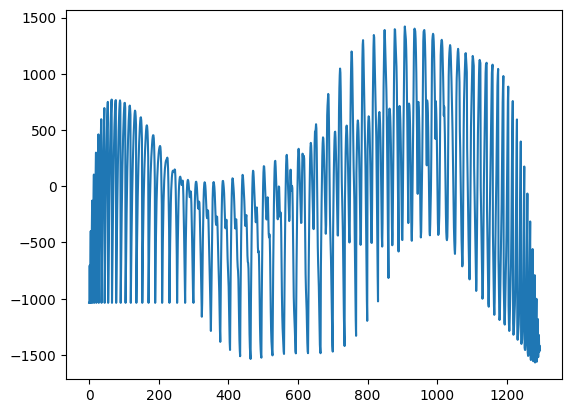

In [9]:
plt.plot(Uh_POD_NN)
plt.show()

### Save the POD-NN solution in numpy file

In [10]:
np.save('Uh_POD_NN',Uh_POD_NN)